In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


2025-04-11 05:24:50.645297: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 05:24:50.648738: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 05:24:50.657892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744349090.672633   46100 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744349090.676975   46100 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744349090.696091   46100 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Ask user for stock symbol
ticker = input("Enter stock ticker (e.g. AAPL, TSLA, MSFT): ").upper()

# Download stock data from 2020 to 2024
data = yf.download(ticker, start='2020-01-01', end='2025-01-01')
data = data[['Close']]

# Show full date range
print(f"\nData range for {ticker}: {data.index.min().date()} to {data.index.max().date()}")

# Add 'Year' column to verify all years exist
data['Year'] = data.index.year
print("\n📅 Rows per year:")
print(data['Year'].value_counts().sort_index())

# Preview first and last 5 rows
print("\nFirst 5 rows:")
print(data.head())
print("\nLast 5 rows:")
print(data.tail())

# Optional: show a couple rows from each year
for y in range(2020, 2025):
    print(f"\n— Sample rows from {y} —")
    display(data[data['Year'] == y].head(2))
    

Enter stock ticker (e.g. AAPL, TSLA, MSFT):  NVDA


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Data range for NVDA: 2020-01-02 to 2024-12-31

📅 Rows per year:
Year
2020    253
2021    252
2022    251
2023    250
2024    252
Name: count, dtype: int64

First 5 rows:
Price          Close  Year
Ticker          NVDA      
Date                      
2020-01-02  5.972162  2020
2020-01-03  5.876572  2020
2020-01-06  5.901215  2020
2020-01-07  5.972659  2020
2020-01-08  5.983860  2020

Last 5 rows:
Price            Close  Year
Ticker            NVDA      
Date                        
2024-12-24  140.207108  2024
2024-12-26  139.917130  2024
2024-12-27  136.997391  2024
2024-12-30  137.477356  2024
2024-12-31  134.277649  2024

— Sample rows from 2020 —


Price,Close,Year
Ticker,NVDA,
Date,,
2020-01-02,5.972162,2020
2020-01-03,5.876572,2020



— Sample rows from 2021 —


Price,Close,Year
Ticker,NVDA,
Date,,
2021-01-04,13.079099,2021
2021-01-05,13.369584,2021



— Sample rows from 2022 —


Price,Close,Year
Ticker,NVDA,
Date,,
2022-01-03,30.068222,2022
2022-01-04,29.238680,2022



— Sample rows from 2023 —


Price,Close,Year
Ticker,NVDA,
Date,,
2023-01-03,14.303279,2023
2023-01-04,14.736923,2023



— Sample rows from 2024 —


Price,Close,Year
Ticker,NVDA,
Date,,
2024-01-02,48.149918,2024
2024-01-03,47.551140,2024


In [3]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close']])

X, y = [], []
seq_len = 60

for i in range(seq_len, len(scaled_data)):
    X.append(scaled_data[i-seq_len:i])
    y.append(scaled_data[i])

X = np.array(X)
y = np.array(y)

# Confirm shape before reshape
print(f"\nX shape before reshape: {X.shape}")

# Reshape X for LSTM [samples, time_steps, features]
if len(X.shape) == 3:
    pass  # already shaped correctly
elif len(X.shape) == 2:
    X = X.reshape((X.shape[0], X.shape[1], 1))
else:
    raise ValueError("Unexpected shape for X!")

print(f"X shape after reshape: {X.shape}")



X shape before reshape: (1198, 60, 1)
X shape after reshape: (1198, 60, 1)


In [4]:
# Preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close']])

X, y = [], []
seq_len = 60

for i in range(seq_len, len(scaled_data)):
    X.append(scaled_data[i-seq_len:i])
    y.append(scaled_data[i])

X = np.array(X)
y = np.array(y)

if len(X) == 0 or len(y) == 0:
    raise ValueError("❌ Not enough data to train. Try reducing seq_len or check dataset length.")

# Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"✅ Data ready for training: X={X.shape}, y={y.shape}")

# Build model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train
model.fit(X, y, epochs=5, batch_size=32)

✅ Data ready for training: X=(1198, 60, 1), y=(1198, 1)
Epoch 1/5


2025-04-11 05:25:00.711448: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0380
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0026
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0029
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0023
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0020


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


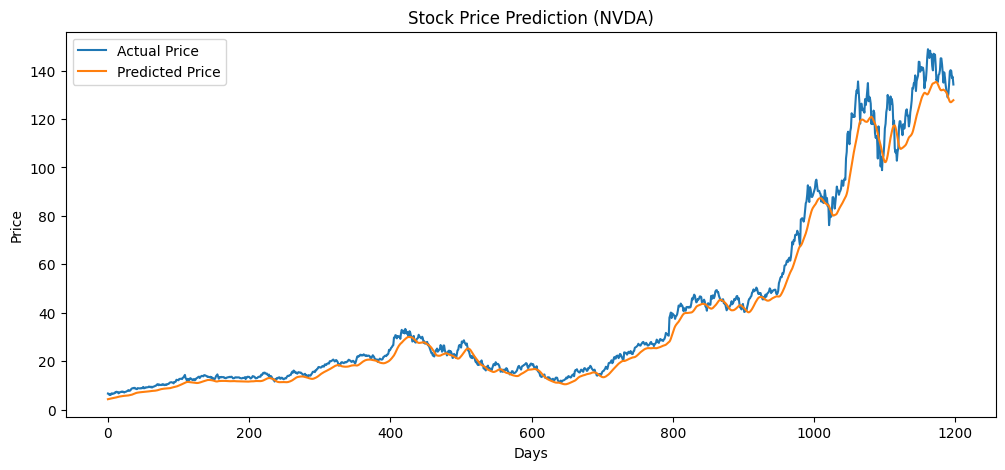

In [5]:
# Make prediction
predicted = model.predict(X)

# Inverse transform (scaling back to original prices)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y.reshape(-1, 1))

# Plotting results
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'Stock Price Prediction ({ticker})')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

Epoch 1/50


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0200
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0035
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0038
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0024
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0026
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0020
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0022
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0021
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0021
Epoch 16/50
38/

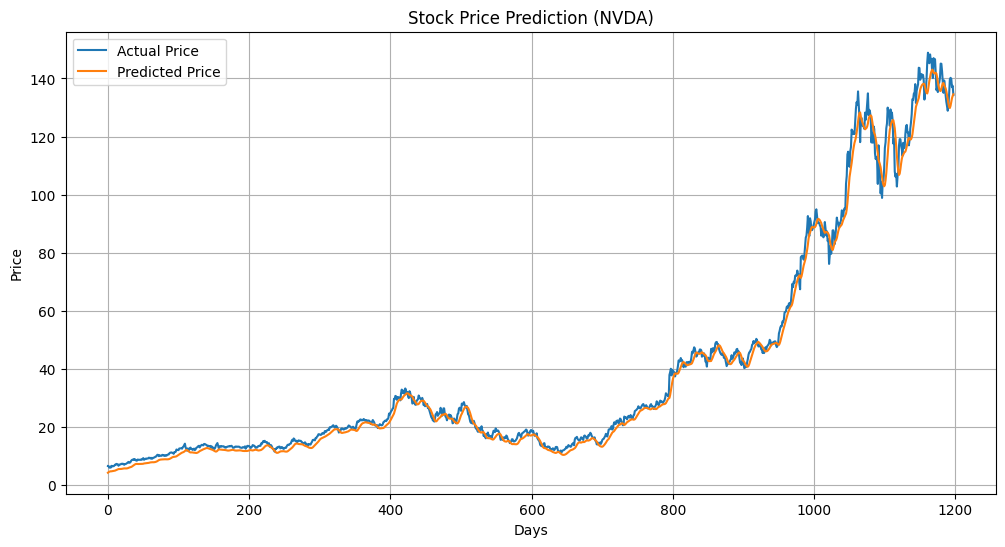

In [6]:
# Build a stronger LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile with RMSprop optimizer (works better for RNNs)
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# Train for more epochs
history = model.fit(X, y, epochs=50, batch_size=32, verbose=1)

# Predict
predicted = model.predict(X)

# Inverse transform predictions and actuals
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y.reshape(-1, 1))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'Stock Price Prediction ({ticker})')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

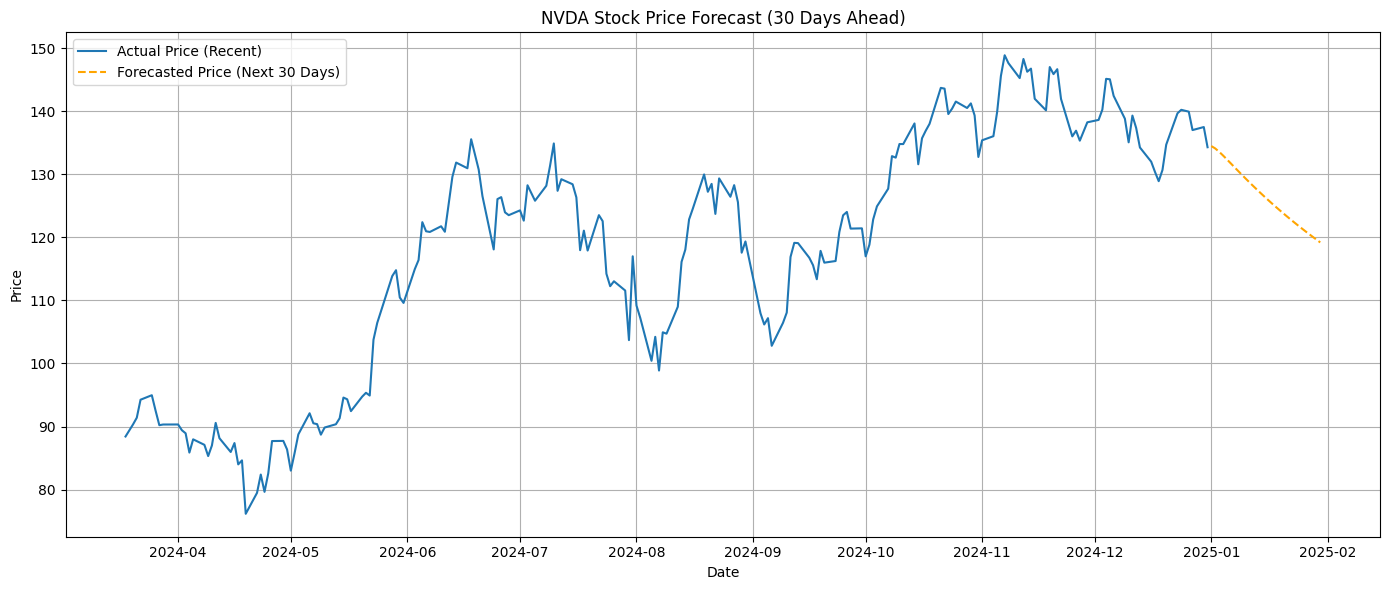

In [7]:
# 📈 Forecast Next N Days
N = 30  # Number of days to forecast into the future

# Use last 60 days of scaled data to start prediction
last_60_days = scaled_data[-60:]
future_predictions_scaled = []

# Loop through and predict one day at a time
for _ in range(N):
    input_seq = last_60_days.reshape(1, 60, 1)
    next_scaled = model.predict(input_seq)[0][0]
    future_predictions_scaled.append(next_scaled)
    
    # Slide the window forward
    last_60_days = np.append(last_60_days, [[next_scaled]], axis=0)[-60:]

# Convert predictions back to original price scale
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# 📅 Create future date range to label the forecast
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=N)

# 📊 Plot historical + forecast
plt.figure(figsize=(14, 6))
plt.plot(data.index[-200:], data['Close'].values[-200:], label='Actual Price (Recent)')
plt.plot(future_dates, future_predictions, label='Forecasted Price (Next 30 Days)', linestyle='--', color='orange')
plt.title(f"{ticker} Stock Price Forecast ({N} Days Ahead)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Enter number of days into the future to predict (max 365):  15


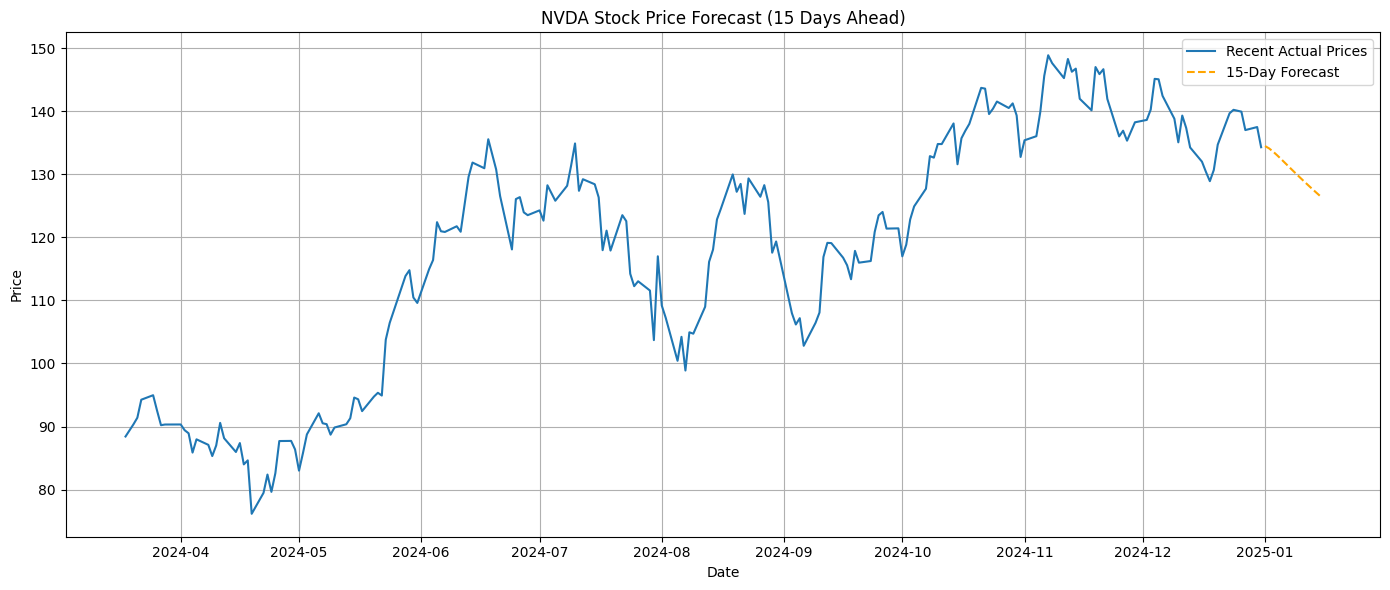


📈 Predicted price of NVDA after 15 days: $126.53


In [8]:
# 🔮 Forecast up to 365 days into the future
max_days = 365
N = int(input(f"Enter number of days into the future to predict (max {max_days}): "))

# Cap it at 365 if user enters too much
if N > max_days:
    print(f"⚠️ Max allowed is {max_days}. Setting N = {max_days}.")
    N = max_days

# Use last 60 days of data
recent_data = scaled_data[-60:]
future_input = recent_data.copy()
future_predictions_scaled = []

for _ in range(N):
    prediction_input = future_input.reshape(1, 60, 1)
    next_pred_scaled = model.predict(prediction_input, verbose=0)[0][0]
    future_predictions_scaled.append(next_pred_scaled)
    
    # Slide window forward
    future_input = np.append(future_input, [[next_pred_scaled]], axis=0)[-60:]

# Convert all predicted values back to actual prices
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# 📅 Generate future dates for labeling
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=N)

# 📈 Plot
plt.figure(figsize=(14, 6))
plt.plot(data.index[-200:], data['Close'].values[-200:], label='Recent Actual Prices')
plt.plot(future_dates, future_predictions, label=f'{N}-Day Forecast', linestyle='--', color='orange')
plt.title(f"{ticker} Stock Price Forecast ({N} Days Ahead)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📢 Final result: Print last forecasted price
final_price = future_predictions[-1][0]
print(f"\n📈 Predicted price of {ticker} after {N} days: ${final_price:.2f}")
